In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers, initializers
from keras.utils.vis_utils import plot_model
from tqdm import tqdm
from tensorflow import keras
from IPython.display import clear_output, display

2023-05-31 19:22:05.494710: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 19:22:05.561087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 19:22:05.562394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 19:22:06.693113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Autocolorizer
The aim of the project is to be able to **colourise old photographs**. The program takes as input a black and white image and is able to outpute the same image with colour. The architecture is based on this paper: https://arxiv.org/pdf/1611.07004.pdf

In [3]:
PATH_TEST = "./data/test/"
PATH_DEVEL = "./data/validation/"
PATH_TRAIN = "./data/train/"
PATH_GENERATOR = "./generator/"

In [4]:
# The facade training set consist of 400 images
BUFFER_SIZE = 100
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

## Loading the data

In [5]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

2023-05-31 19:22:09.349084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-31 19:22:09.350264: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Text(0.5, 1.0, 'real image')

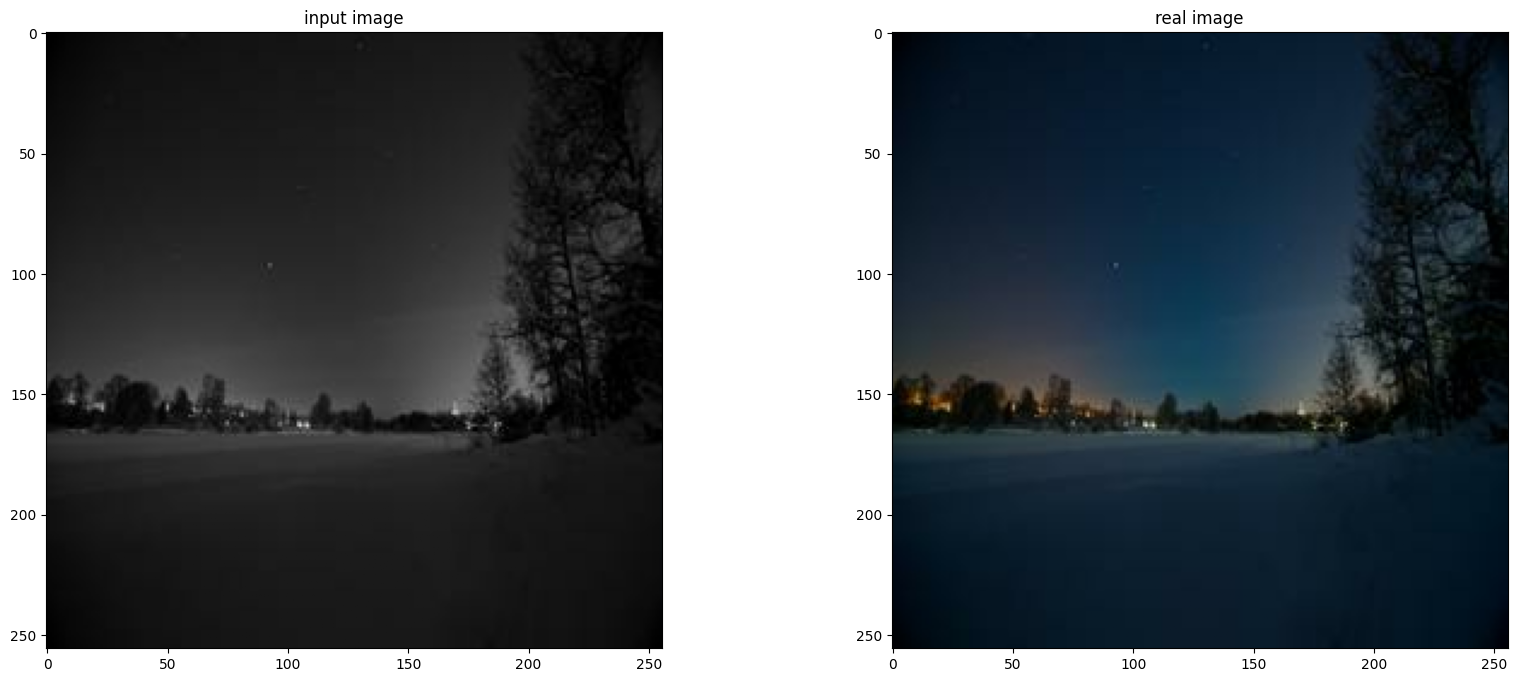

In [6]:
inp, re = load(PATH_TRAIN + '00000001.jpg')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(inp/255.0)
ax1.set_title('input image')
ax2.imshow(re/255.0)
ax2.set_title('real image')

## Pre-processing the data
* normalize to [-1, 1]
* resize to IMG_HEIGHT and IMG_WIDTH
* random cut
* random jitter (*random jitter*):
   * In this process, as mentioned in the paper, the image is resized to a larger size, then a random cut of the original size is made and then a horizontal flip is also made randomly. Below are 4 examples.

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

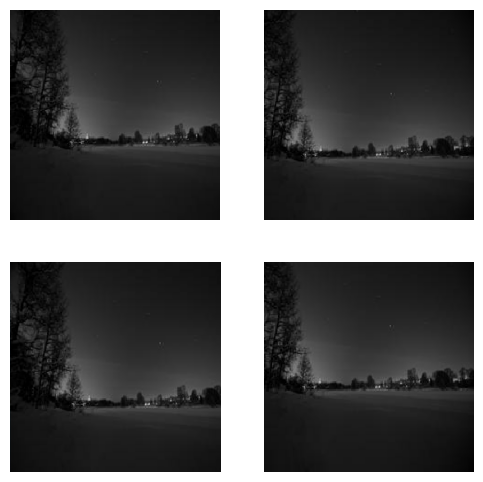

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [12]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [14]:
train_dataset = tf.data.Dataset.list_files(PATH_TRAIN+'*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
val_dataset = tf.data.Dataset.list_files(PATH_DEVEL+'*.jpg')
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [16]:
test_dataset = tf.data.Dataset.list_files(PATH_TEST+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## pix2pix architecture

This code is based on the **pix2pix** architecture. Despite having a generator and a discriminator with opposite objectives in search of a Nash equilibrium, this architecture is different from normal GANs as it does not take random noise (latent space) as input, in this one instead we take a whole image *x* as input. Our goal is to **translate** it into another image with a similar structure. That is, our generator *G* has to produce *G(X)* which will have to be indistinguishable from *y* (the other image with a similar structure) for our discriminator *D*.


Its main parts are:

- **U-NET generator**: the pix2pix generator looks very much like an **autoencoder**. It takes the image to be translated, compresses it to a lower dimensional space called **Bottleneck** and then learns upsampling from the extracted features to get the desired image as output. 

  It also has some similarities to a ResNet in the way information from previous layers is fed to the next layers using so-called **skip connections**. In this architecture we have skip connections that leave the encoder half of the network and go to the other decoder half. This serves to prevent us from losing information at the bottleneck.
  

- **Patch-GAN discriminator**: in this discriminator, instead of taking the images and classifying them as true or false, different pieces of the image are classified individually, thus reinforcing the objective of achieving much sharper details. It is also faster to classify a whole image as it only has to classify small chunks and that means fewer parameters.

### Auxiliary blocks

Here we will define the downsample and upsample blocks. This is useful because the generator (U-NET) has both and the discriminator (Patch-GAN) also downsamples. It also makes the code more readable as the blocks are repeated several times.

In [17]:
OUTPUT_CHANNELS = 3

In [18]:
# Encoder: Convolution -> Batch normalization -> Leaky ReLu
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [19]:
# Decoder: Transposed convolution -> Batch normalization -> 
#           -> Dropout (applied to the first 3 blocks) -> ReLU
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
     
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


### Generator

In [20]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
generator = Generator()
plot_model(generator, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_3 (Sequential)      (None, 64, 64, 128)  131584      ['sequential_2[0][0]']           
                                                                                              

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


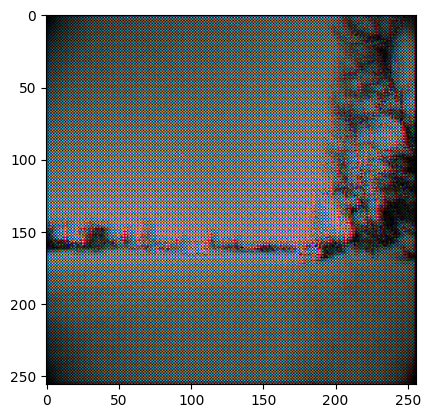

In [22]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Discriminator

In [24]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [25]:
discriminator = Discriminator()
plot_model(discriminator, to_file='./discriminator_model_plot.png', show_shapes=True, show_layer_names=True)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

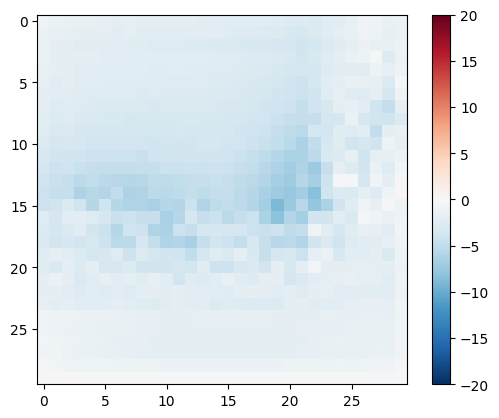

In [26]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Losses

In [ ]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
     
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [27]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Optimizers and checkpoints

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

2023-05-31 19:22:17.041350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:22:17.041890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


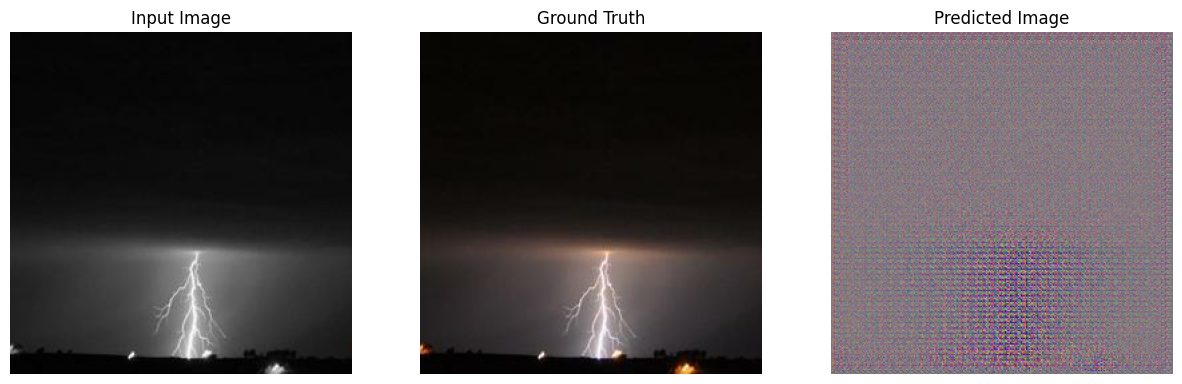

In [31]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

In [32]:
@tf.function
def train_step(input_image, target, g_loss_metric, g_l1_loss_metric,g_gan_loss_metric, d_loss_metric):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
  # Update the metrics
  g_loss_metric.update_state(gen_total_loss)
  g_l1_loss_metric.update_state(gen_l1_loss)
  g_gan_loss_metric.update_state(gen_gan_loss)
  d_loss_metric.update_state(disc_loss)
  
  # accuracy_metric.update_state(tf.ones_like(gen_output), gen_output)
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))



In [33]:
def generate_images(model, test_input, tar, base_path='./results', epoch=0):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  if not os.path.exists(base_path):
    os.makedirs(base_path)

  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(base_path + '/result_{}.png'.format(epoch))
  plt.close()


In [34]:
def plot_losses(g_loss, d_loss, epoch, dataset):
    """Plot the losses each epoc during training."""
    total_loss = [g[0].numpy() + d[0].numpy() for g, d in zip(g_loss, d_loss)]
    g_loss = [g[0].numpy() for g in g_loss]
    d_loss = [d[0].numpy() for d in d_loss]
    plt.figure(figsize=(10,5))
    plt.plot(g_loss, label='gen')
    plt.plot(d_loss, label='disc')
    plt.plot(total_loss, label='total')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('training loss')
    plt.savefig('results/losses.png')
    plt.close()

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
    xs = [_ for _ in range(len(d_loss))]
    if len(xs) > 20:
        window=5
        f, axarr = plt.subplots(2, figsize=(8,4), sharex=True)
        axarr[0].plot(d_loss, alpha=0.4, linewidth=5)
        axarr[0].plot(xs[window:-window], smooth(d_loss, window)[window:-window], c='C0')
        axarr[0].set_title('Discriminator')
        axarr[0].set_yscale('log')
        axarr[0].set_ylabel('loss')
        axarr[1].plot(g_loss, alpha=0.4, linewidth=5)
        axarr[1].plot(xs[window:-window], smooth(g_loss, window)[window:-window], c='C1')
        axarr[1].set_title('Generator')
        axarr[1].set_xlabel('Epoch')
        axarr[1].set_ylabel('loss')
        plt.savefig('results/loss_tracking.png')
        plt.close()


In [36]:
def train(dataset, epochs):
  # Create the metrics
  g_loss_log = []
  g_l1_loss_log = []
  g_gan_loss_log = []
  d_loss_log = []
  g_loss_metric = tf.keras.metrics.Mean(name='g_train_loss')
  g_l1_loss_metric = tf.keras.metrics.Mean(name='g_l1_train_loss')
  g_gan_loss_metric =tf.keras.metrics.Mean(name='g_gan_train_loss')
  d_loss_metric = tf.keras.metrics.Mean(name='d_train_loss')
  # accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  for epoch in range(epochs):
    start = time.time()
    # Reset the metrics
    g_loss_metric.reset_states()
    g_l1_loss_metric.reset_states()
    g_gan_loss_metric.reset_states()
    d_loss_metric.reset_states()
    # accuracy_metric.reset_states()
    counter = 0
    for input_image, target in tqdm(dataset):
      train_step(input_image, target, g_loss_metric, g_l1_loss_metric, g_gan_loss_metric,d_loss_metric)
      counter += 1
      if counter > 100:
        break
    # Get the metric results
    g_mean_loss = g_loss_metric.result()
    g_mean_l1_loss = g_l1_loss_metric.result()
    g_mean_gan_loss = g_gan_loss_metric.result()
    d_mean_loss = d_loss_metric.result()
    
    g_loss_log.append([g_mean_loss])
    g_l1_loss_log.append([g_mean_l1_loss])
    g_gan_loss_log.append([g_mean_gan_loss])
    d_loss_log.append([d_mean_loss])
    # mean_accuracy = accuracy_metric.result()
    #
    print('Epoch: ', epoch)
    print(f'  loss (g_gan) (g_l1) (g) (d) (g+d): {g_mean_gan_loss:.3f}, {g_mean_l1_loss:.3f}, {g_mean_loss:.3f}, {d_mean_loss:.3f}, {g_mean_loss + d_mean_loss:.3f}')

    # if (epoch) % 5 == 0:
    for i, (inp, tar) in enumerate(test_dataset.take(10)):
      generate_images(generator, inp, tar, base_path='results/{}'.format(i), epoch=epoch)
      # clear_output(wait=True)
      plot_losses(g_loss_log, d_loss_log, epoch=epoch, dataset='dataset')

    # saving (checkpoint) the model every 20 epochs
    # if (epoch + 1) % 20 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

train(train_dataset, 16)                                                                  

  3%|▎         | 100/3645 [03:18<1:57:26,  1.99s/it]
2023-05-31 19:26:05.550105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:26:05.550648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  0
  loss (g_gan) (g_l1) (g) (d) (g+d): 0.790, 0.207, 21.460, 1.448, 22.908
Time taken for epoch 1 is 208.2248351573944 sec



  3%|▎         | 100/3645 [03:10<1:52:39,  1.91s/it]
2023-05-31 19:29:25.679644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:29:25.680800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  1
  loss (g_gan) (g_l1) (g) (d) (g+d): 0.796, 0.147, 15.508, 1.356, 16.863
Time taken for epoch 2 is 200.737952709198 sec



  3%|▎         | 100/3645 [03:13<1:54:34,  1.94s/it]
2023-05-31 19:32:49.632469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:32:49.633093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  2
  loss (g_gan) (g_l1) (g) (d) (g+d): 0.902, 0.158, 16.751, 1.275, 18.027
Time taken for epoch 3 is 203.58679294586182 sec



  3%|▎         | 100/3645 [03:03<1:48:11,  1.83s/it]
2023-05-31 19:36:02.432116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:36:02.433277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  3
  loss (g_gan) (g_l1) (g) (d) (g+d): 0.993, 0.156, 16.548, 1.257, 17.805
Time taken for epoch 4 is 192.96498107910156 sec



  3%|▎         | 100/3645 [03:03<1:48:25,  1.84s/it]
2023-05-31 19:39:15.803337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:39:15.804516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  4
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.018, 0.156, 16.577, 1.264, 17.841
Time taken for epoch 5 is 192.7273828983307 sec



  3%|▎         | 100/3645 [03:04<1:49:13,  1.85s/it]
2023-05-31 19:42:29.878142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:42:29.878813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  5
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.078, 0.142, 15.230, 1.228, 16.458
Time taken for epoch 6 is 194.76145601272583 sec



  3%|▎         | 100/3645 [03:14<1:54:52,  1.94s/it]
2023-05-31 19:45:54.186590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:45:54.187450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  6
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.020, 0.142, 15.251, 1.273, 16.523
Time taken for epoch 7 is 203.45952892303467 sec



  3%|▎         | 100/3645 [03:03<1:48:15,  1.83s/it]
2023-05-31 19:49:06.452750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:49:06.453316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  7
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.124, 0.153, 16.400, 1.148, 17.548
Time taken for epoch 8 is 193.4913740158081 sec



  3%|▎         | 100/3645 [03:02<1:48:01,  1.83s/it]
2023-05-31 19:52:19.557386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:52:19.558322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  8
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.111, 0.129, 14.000, 1.165, 15.165
Time taken for epoch 9 is 192.15274024009705 sec



  3%|▎         | 100/3645 [03:01<1:47:26,  1.82s/it]
2023-05-31 19:55:30.725516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:55:30.726062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  9
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.123, 0.149, 16.056, 1.146, 17.203
Time taken for epoch 10 is 191.35060691833496 sec



  3%|▎         | 100/3645 [03:06<1:50:16,  1.87s/it]
2023-05-31 19:58:46.865110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 19:58:46.865662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  10
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.265, 0.155, 16.777, 1.077, 17.854
Time taken for epoch 11 is 196.89215540885925 sec



  3%|▎         | 100/3645 [03:06<1:50:22,  1.87s/it]
2023-05-31 20:02:03.915943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 20:02:03.917150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  11
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.245, 0.134, 14.616, 1.053, 15.668
Time taken for epoch 12 is 196.57487750053406 sec



  3%|▎         | 100/3645 [03:06<1:50:19,  1.87s/it]
2023-05-31 20:05:20.413344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 20:05:20.413847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  12
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.331, 0.131, 14.418, 0.968, 15.385
Time taken for epoch 13 is 196.41881394386292 sec



  3%|▎         | 100/3645 [02:40<1:34:36,  1.60s/it]
2023-05-31 20:08:10.236871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 20:08:10.237325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  13
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.477, 0.153, 16.823, 1.003, 17.826
Time taken for epoch 14 is 168.8662371635437 sec



  3%|▎         | 100/3645 [02:59<1:46:19,  1.80s/it]
2023-05-31 20:11:18.941322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 20:11:18.942604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  14
  loss (g_gan) (g_l1) (g) (d) (g+d): 1.407, 0.147, 16.105, 0.942, 17.047
Time taken for epoch 15 is 191.5904188156128 sec



  3%|▎         | 100/3645 [02:38<1:33:33,  1.58s/it]
2023-05-31 20:14:08.908802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 20:14:08.910004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Epoch:  15
  loss (g_gan) (g_l1) (g) (d) (g+d): 2.023, 0.158, 17.846, 0.699, 18.545
Time taken for epoch 16 is 167.28239798545837 sec



In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [36]:
for inp, tar in test_dataset:
  generate_images(generator, inp, tar, base_path='results/0', epoch=4)


2023-05-31 11:18:12.353432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-31 11:18:12.354063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


## Saving the models

In [ ]:
if not os.path.exists(PATH_GENERATOR):
  os.makedirs(PATH_GENERATOR)
generator.save(PATH_GENERATOR+'generator_final.h5')

In [ ]:
if not os.path.exists(PATH_GENERATOR):
  os.makedirs(PATH_GENERATOR)
discriminator.save(PATH_GENERATOR+'discriminator_final.h5')

In [ ]:
new_model = keras.models.load_model(PATH_GENERATOR+'final.h5')

for inp, tar in test_dataset.take(10):
  generate_images(new_model, inp, tar)

In [ ]:
# def save(gan, generator, discriminator):
#     discriminator.trainable = False
#     gan.save('gan.h5')
#     discriminator.trainable = True
#     generator.save('generator.h5')
#     discriminator.save('discriminator.h5')


# def load():
#     discriminator = keras.models.load_model('discriminator.h5')
#     generator = keras.models.load_model('generator.h5')
#     gan = keras.models.load_model('gan.h5')
#     gan.summary()
#     discriminator.summary()
#     generator.summary()

#     return gan, generator, discriminator